In [3]:
import random
import multiprocessing as mp


class Item:
    def __init__(self, name, weight, value):
        self.name = name
        self.weight = weight
        self.value = value
    
    def __str__(self):
        return f"name: {self.name} weight: {self.weight} value: {self.value}"
    
    def __repr__(self):
        return str(self)


class Individual:
    def __init__(self, counts):
        self.counts = counts
    
    def __str__(self):
        return repr(self.counts)

    def __hash__(self):
        return hash(str(self.counts))
    
    def __eq__(self, other):
        return self.counts == other.counts
    
    def fitness(self) -> float:
        total_value = sum([
            count * item.value
            for item, count in zip(items, self.counts)
        ])

        total_weight = sum([
            count * item.weight
            for item, count in zip(items, self.counts)
        ])

        if total_weight <= MAX_KNAPSACK_WEIGHT:
            return total_value
        
        return 0



MAX_KNAPSACK_WEIGHT = 503
MUTATION_RATE = 0.02
REPRODUCTION_RATE = 0.1
POPULATION_COUNT = 30
DIFF_PRECISION = 0.05
STOP_EPOCH_NUM = 5
NUM_OF_POPUlATIONS = 50 
MIGRATION_PERIOD = 5
BEST_IN_MIGRATION = 4
IMMIGRANTS_NUM = 3

EPOCHS = 500 

# best result 1256
items = [
    Item("A", 1, 1), # 0
    Item("B", 3, 7), # 1
    Item("C", 4, 9), # 1
    Item("D", 6, 5), # 0
    Item("E", 8, 20), #  62
    Item("F", 10, 13), # 0
    Item("G", 21, 27), # 0
    Item("H", 7, 9), # 0
    Item("I", 5, 8), # 0
    Item("K", 9, 13), # 0
]

def generate_initial_population(population_count=POPULATION_COUNT):
    population = set()
    while len(population) != population_count:
        idxs = list(range(len(items)))
        random.shuffle(idxs)
        counts = [0 for i in range(len(items))]
        W = MAX_KNAPSACK_WEIGHT
        for idx in idxs[:-1]:
            i = items[idx]
            count = random.randint(0, W // i.weight)
            counts[idx] = count
            W -= count * i.weight
        counts[idxs[-1]] = W // items[idxs[-1]].weight
        population.add(Individual(counts))
    return list(population)


def selection(population):
    parents = []
    
    random.shuffle(population)
    
    if population[0].fitness() > population[1].fitness():
        parents.append(population[0])
    else:
        parents.append(population[1])
    
    if population[2].fitness() > population[3].fitness():
        parents.append(population[2])
    else:
        parents.append(population[3])

    return parents


def crossover(parents):
    N = len(items)

    crosscover_point = random.randint(1, N-2)
    child1 = Individual(parents[0].counts[:crosscover_point] + parents[1].counts[crosscover_point:])
    child2 = Individual(parents[1].counts[:crosscover_point] + parents[0].counts[crosscover_point:])

    return [child1, child2]



def mutate(individuals):
    for individual in individuals:
        if not individual.fitness():
            continue
        if random.random() < MUTATION_RATE:
            for _ in range(random.randint(len(individual.counts) // 2, len(individual.counts))):
                w = MAX_KNAPSACK_WEIGHT
                gen = random.randint(0, len(individual.counts)-1)
                for i in range(len(individual.counts)):
                    if i == gen:
                        continue
                    w -= individual.counts[i] * items[i].weight
                individual.counts[gen] = random.randint(0, w // items[gen].weight)
    return individuals


def next_generation(population):
    next_gen = []
    while len(next_gen) < len(population):
        children = []

        #selection
        parents = selection(population)

        # reproduction
        if random.random() < REPRODUCTION_RATE:
            children = parents
        else:
            # crossover
            children = crossover(parents)
            
            # mutation
            if random.random() < MUTATION_RATE:
                children = mutate(children)

        if children[0].fitness():
            next_gen.append(children[0])
        if children[1].fitness():
            next_gen.append(children[1])
    
    next_gen.extend(population)

    n_sorted = sorted(next_gen, key=lambda x: x.fitness(), reverse=True)

    new_population = []
    population_len = len(n_sorted)
    rank = 0
    while len(new_population) != POPULATION_COUNT:
        if random.random() < (population_len - rank) / population_len:
            new_population.append(n_sorted[rank])
        rank = (rank + 1) % population_len
    return sorted(new_population, key=lambda i: i.fitness(), reverse=True)
        


def print_generation(population):
    for individual in population:
        total_weight = sum([
            count * item.weight
            for item, count in zip(items, individual.counts)
        ])
        print(individual.counts, 'fitness', individual.fitness(), 'total_weight', total_weight)
    print()
    print("Average fitness", average_fitness(population))
    print("-" * 32)


def average_fitness(population):
    return sum([i.fitness() for i in population]) / len(population)


def solve_knapsack(population):
    avg_fitness = []
    for _ in range(MIGRATION_PERIOD):
        population = next_generation(population)
        avg_fitness.append(average_fitness(population))
        # среднее значение функции приспособленности за последние 5 эпох не отличается от последнего значения
        if len(avg_fitness) > 5 and abs((sum(avg_fitness[-5:]) / 5) / avg_fitness[-1] - 1) < DIFF_PRECISION:
            break
    return sorted(population, key=lambda i: i.fitness(), reverse=True)


def migrations(populations):
    bestI = []
    for population in populations:
        bestI.extend(population[:BEST_IN_MIGRATION])
    
    for population in populations:
        for i in range(IMMIGRANTS_NUM):
            best = random.choice(bestI)
            if population[-i-1].fitness() < best.fitness():
                population[-i-1] = best

def parallel_knapsack():
    populations = []
    for _ in range(NUM_OF_POPUlATIONS):
        populations.append(generate_initial_population())
    
    
    pool = mp.Pool(processes=len(populations))
    
    prev_fitness = 0 
    for _ in range(EPOCHS // MIGRATION_PERIOD):
        # print(f"migration period {i}")
        populations = pool.map(solve_knapsack, populations)
        migrations(populations)

        best = populations[0][0]
        for population in populations[1:]:
            if population[0].fitness() > best.fitness():
                best = population[0]
        if best.fitness() == prev_fitness:
            break 
        prev_fitness = best.fitness()
    
    # for i in range(len(populations)):
    #     print(f"популяция {i}")
    #     print_generation(populations[i])

    return best

In [4]:
best_fitness = 1256
decision = [0, 1, 1, 0, 62, 0, 0, 0, 0, 0]

error = 0
counter = 0
for i in range(100):
    solution = parallel_knapsack()
    if solution.counts == decision:
        counter += 1
    error += abs(solution.fitness() - best_fitness)
    print(solution.counts, solution.fitness())

counter, error / 100

[4, 1, 0, 0, 62, 0, 0, 0, 0, 0] 1251
[1, 0, 0, 0, 62, 0, 0, 0, 1, 0] 1249
[0, 1, 3, 0, 61, 0, 0, 0, 0, 0] 1254
[1, 2, 0, 0, 62, 0, 0, 0, 0, 0] 1255
[3, 0, 1, 0, 62, 0, 0, 0, 0, 0] 1252
[1, 2, 0, 0, 62, 0, 0, 0, 0, 0] 1255
[1, 2, 0, 0, 62, 0, 0, 0, 0, 0] 1255
[3, 0, 3, 0, 61, 0, 0, 0, 0, 0] 1250
[0, 6, 0, 0, 60, 0, 0, 0, 1, 0] 1250
[1, 2, 0, 0, 62, 0, 0, 0, 0, 0] 1255
[0, 1, 1, 0, 62, 0, 0, 0, 0, 0] 1256
[0, 1, 1, 0, 62, 0, 0, 0, 0, 0] 1256
[0, 0, 0, 0, 62, 0, 0, 1, 0, 0] 1249
[1, 2, 0, 0, 62, 0, 0, 0, 0, 0] 1255
[2, 0, 2, 0, 61, 0, 0, 0, 1, 0] 1248
[0, 1, 1, 0, 62, 0, 0, 0, 0, 0] 1256
[0, 1, 1, 0, 62, 0, 0, 0, 0, 0] 1256
[0, 5, 0, 0, 61, 0, 0, 0, 0, 0] 1255
[3, 0, 1, 0, 62, 0, 0, 0, 0, 0] 1252
[3, 4, 0, 0, 61, 0, 0, 0, 0, 0] 1251
[1, 3, 2, 0, 60, 0, 0, 0, 1, 0] 1248
[1, 2, 0, 0, 62, 0, 0, 0, 0, 0] 1255
[0, 1, 1, 0, 62, 0, 0, 0, 0, 0] 1256
[1, 2, 0, 0, 62, 0, 0, 0, 0, 0] 1255
[1, 2, 0, 0, 62, 0, 0, 0, 0, 0] 1255
[3, 0, 1, 0, 62, 0, 0, 0, 0, 0] 1252
[0, 1, 1, 0, 62, 0, 0, 0, 0, 0] 1256
[

(17, 3.5)

In [5]:
params = {
    "mutation_rate": [0.005, 0.02, 4],
    "reproduction_rate": [0.1, 0.4, 4],
    "population_count": [20, 30, 2],
    "num_of_populations": [10, 10, 1],
    "migration_period": [5, EPOCHS//10, EPOCHS//10//11],
    "best_in_migration": [3, 5, 3],
    "immigrants_num": [1, 3, 3],
}

In [6]:
import time
import numpy as np
from tqdm import tqdm

In [17]:
# pd.read_csv("./learning_results.csv")
result = []

for mr in tqdm(np.linspace(*params["mutation_rate"])):
    MUTATION_RATE = mr
    for rr in np.linspace(*params["reproduction_rate"]):
        REPRODUCTION_RATE = rr
        print(f"reprod rate = {rr}")
        for pc in np.linspace(*params["population_count"]):
            POPULATION_COUNT = int(pc)
            print(f"pop count = {pc}")
            for nmp in np.linspace(*params["num_of_populations"]):
                NUM_OF_POPUlATIONS = int(nmp)
                for mnp in np.linspace(*params["migration_period"]):
                    MIGRATION_PERIOD = int(mnp)
                    for bm in np.linspace(*params["best_in_migration"]):
                        BEST_IN_MIGRATION = int(bm)
                        for imn in np.linspace(*params["immigrants_num"]):
                            IMMIGRANTS_NUM = int(imn)
                            
                            fitness = []
                            start = time.time()
                            for _ in range(10):
                                solution = parallel_knapsack()
                                fitness.append(solution.fitness())
                            end = (time.time() - start) / 10
                            
                            result.append({
                                "mutation_rate": mr,
                                "reproduction_rate": rr,
                                "population_count": pc,
                                "num_of_populations": nmp,
                                "migration_period": mnp,
                                "best_in_migration": bm,
                                "immigrants_num": imn,
                                "fitness": sum(fitness) / len(fitness),
                                "time": end,
                            })

  0%|                                                     | 0/4 [00:00<?, ?it/s]

reprod rate = 0.1
pop count = 20.0
pop count = 30.0
reprod rate = 0.2
pop count = 20.0
pop count = 30.0
reprod rate = 0.30000000000000004
pop count = 20.0
pop count = 30.0
reprod rate = 0.4
pop count = 20.0
pop count = 30.0


 25%|███████████                                 | 1/4 [03:27<10:21, 207.10s/it]

reprod rate = 0.1
pop count = 20.0
pop count = 30.0
reprod rate = 0.2
pop count = 20.0
pop count = 30.0
reprod rate = 0.30000000000000004
pop count = 20.0
pop count = 30.0
reprod rate = 0.4
pop count = 20.0
pop count = 30.0


 50%|██████████████████████                      | 2/4 [06:56<06:56, 208.27s/it]

reprod rate = 0.1
pop count = 20.0
pop count = 30.0
reprod rate = 0.2
pop count = 20.0
pop count = 30.0
reprod rate = 0.30000000000000004
pop count = 20.0
pop count = 30.0
reprod rate = 0.4
pop count = 20.0
pop count = 30.0


 75%|█████████████████████████████████           | 3/4 [10:27<03:29, 209.53s/it]

reprod rate = 0.1
pop count = 20.0
pop count = 30.0
reprod rate = 0.2
pop count = 20.0
pop count = 30.0
reprod rate = 0.30000000000000004
pop count = 20.0
pop count = 30.0
reprod rate = 0.4
pop count = 20.0
pop count = 30.0


100%|████████████████████████████████████████████| 4/4 [13:56<00:00, 209.17s/it]


In [18]:
result = sorted(result, key=lambda x: x['fitness'], reverse=True)
result[:5]

[{'mutation_rate': 0.01,
  'reproduction_rate': 0.1,
  'population_count': 30.0,
  'num_of_populations': 10.0,
  'migration_period': 5.0,
  'best_in_migration': 4.0,
  'immigrants_num': 3.0,
  'fitness': 1249.6,
  'time': 0.07571825981140137},
 {'mutation_rate': 0.01,
  'reproduction_rate': 0.1,
  'population_count': 20.0,
  'num_of_populations': 10.0,
  'migration_period': 20.0,
  'best_in_migration': 4.0,
  'immigrants_num': 2.0,
  'fitness': 1249.0,
  'time': 0.06936306953430176},
 {'mutation_rate': 0.015,
  'reproduction_rate': 0.2,
  'population_count': 30.0,
  'num_of_populations': 10.0,
  'migration_period': 5.0,
  'best_in_migration': 5.0,
  'immigrants_num': 1.0,
  'fitness': 1247.2,
  'time': 0.0718003749847412},
 {'mutation_rate': 0.005,
  'reproduction_rate': 0.4,
  'population_count': 30.0,
  'num_of_populations': 10.0,
  'migration_period': 35.0,
  'best_in_migration': 4.0,
  'immigrants_num': 3.0,
  'fitness': 1246.3,
  'time': 0.07715599536895752},
 {'mutation_rate': 0.

In [7]:
import seaborn as sns
import pandas as pd

In [10]:
# df = pd.DataFrame(result).drop("num_of_populations", axis=1)
df = pd.read_csv("./learning_results.csv")
df.head()

,mutation_rate,reproduction_rate,population_count,migration_period,best_in_migration,immigrants_num,fitness,time
0,0.010,0.1,30.0,5.0,4.0,3.0,1249.6,0.075718
1,0.010,0.1,20.0,20.0,4.0,2.0,1249.0,0.069363
2,0.015,0.2,30.0,5.0,5.0,1.0,1247.2,0.071800
3,0.005,0.4,30.0,35.0,4.0,3.0,1246.3,0.077156
4,0.010,0.2,20.0,50.0,3.0,1.0,1246.2,0.067084


In [11]:
# df.to_csv("./learning_results.csv", index=False)

In [12]:
cols = list(df.columns)
cols.remove("fitness")
cols

['mutation_rate',
 'reproduction_rate',
 'population_count',
 'migration_period',
 'best_in_migration',
 'immigrants_num',
 'time']

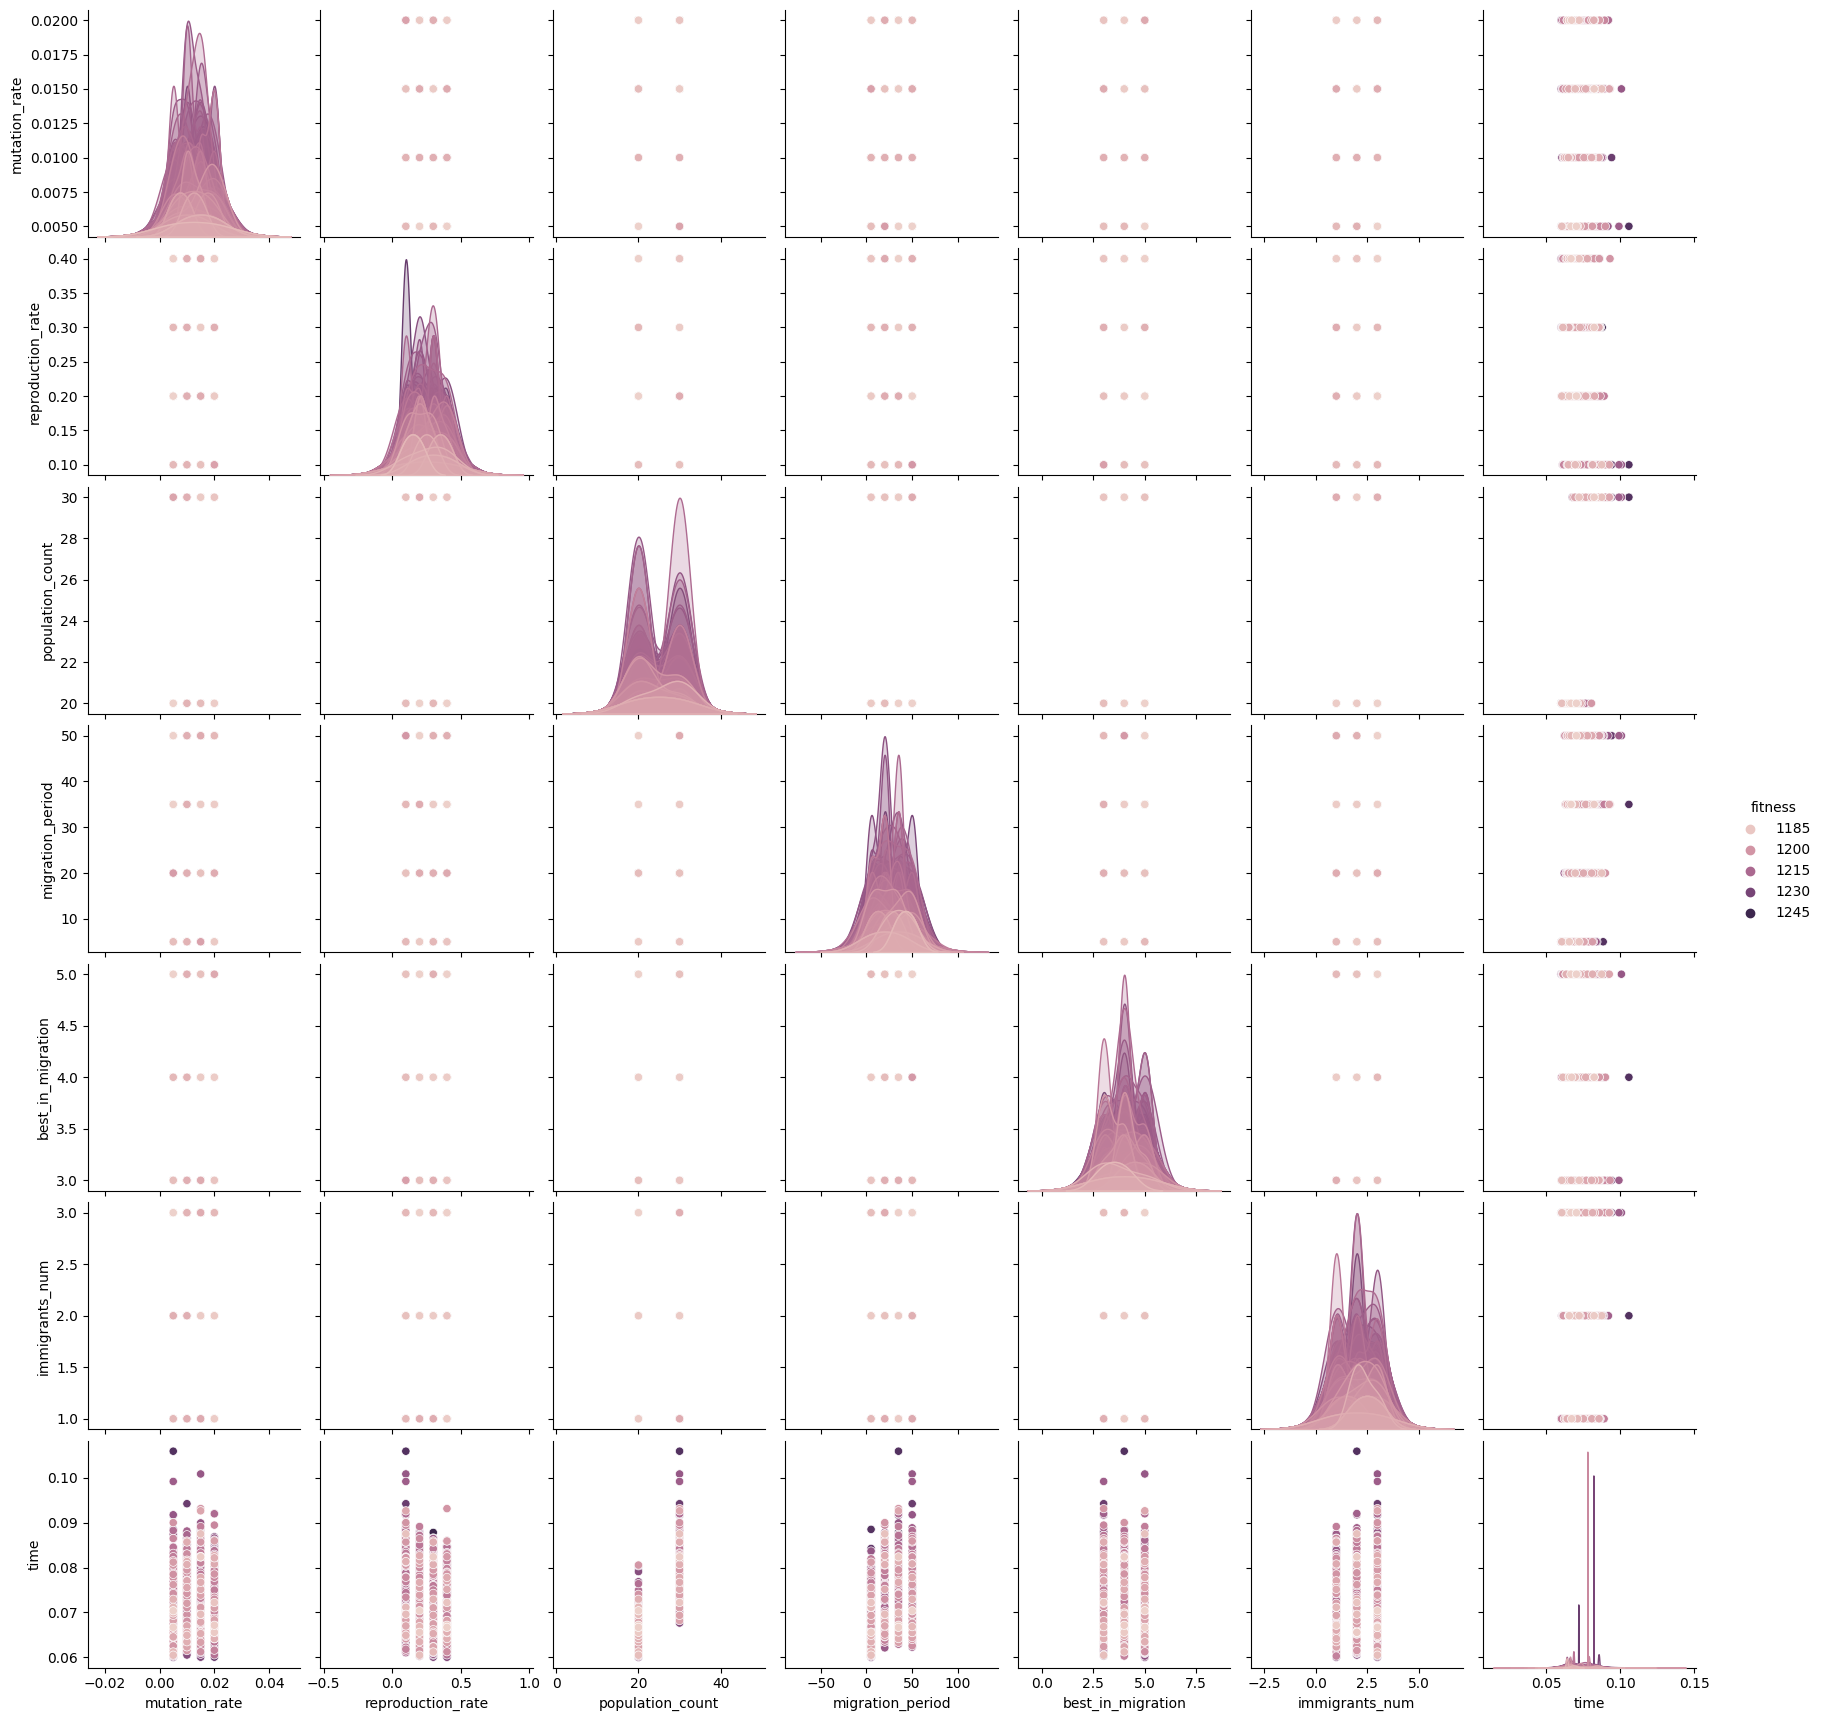

In [29]:
sns.pairplot(df, hue='fitness')

In [79]:
MUTATION_RATE = 0.01
REPRODUCTION_RATE = 0.1
POPULATION_COUNT = 30 
MIGRATION_PERIOD = 5
BEST_IN_MIGRATION = 4
IMMIGRANTS_NUM = 3

In [80]:
result2 = []
for nop in tqdm(range(10, 100, 10)):
    NUM_OF_POPUlATIONS = nop
    
    fitness = []
    start = time.time()
    for _ in range(10):
        solution = parallel_knapsack()
        fitness.append(solution.fitness())
    end = (time.time() - start) / 10
    result2.append({
        "num_of_population": nop,
        "fitness": sum(fitness) / len(fitness),
        "time": end,
    })
    print(f"NUM_OF_POPULATION = {nop}, fitness = {result2[-1]['fitness']}, time = {end}")

result2 = sorted(result2, key=lambda x: x['fitness'], reverse=True)
result2[:5]

 11%|█████                                        | 1/9 [00:02<00:19,  2.50s/it]

NUM_OF_POPULATION = 10, fitness = 1236.4, time = 0.24957585334777832


 22%|██████████                                   | 2/9 [00:06<00:23,  3.32s/it]

NUM_OF_POPULATION = 20, fitness = 1238.8, time = 0.38907084465026853


 33%|███████████████                              | 3/9 [00:12<00:26,  4.48s/it]

NUM_OF_POPULATION = 30, fitness = 1242.2, time = 0.5867852926254272


 44%|████████████████████                         | 4/9 [00:19<00:28,  5.65s/it]

NUM_OF_POPULATION = 40, fitness = 1248.6, time = 0.7429080009460449


 56%|█████████████████████████                    | 5/9 [00:28<00:27,  6.83s/it]

NUM_OF_POPULATION = 50, fitness = 1250.9, time = 0.8925570249557495


 67%|██████████████████████████████               | 6/9 [00:39<00:24,  8.04s/it]

NUM_OF_POPULATION = 60, fitness = 1251.0, time = 1.0400415658950806


 78%|███████████████████████████████████          | 7/9 [00:55<00:21, 10.82s/it]

NUM_OF_POPULATION = 70, fitness = 1253.5, time = 1.651869297027588


 89%|████████████████████████████████████████     | 8/9 [01:05<00:10, 10.42s/it]

NUM_OF_POPULATION = 80, fitness = 1252.9, time = 0.9580232858657837


100%|█████████████████████████████████████████████| 9/9 [01:15<00:00,  8.35s/it]

NUM_OF_POPULATION = 90, fitness = 1253.0, time = 1.0063595056533814


[{'num_of_population': 70, 'fitness': 1253.5, 'time': 1.651869297027588},
 {'num_of_population': 90, 'fitness': 1253.0, 'time': 1.0063595056533814},
 {'num_of_population': 80, 'fitness': 1252.9, 'time': 0.9580232858657837},
 {'num_of_population': 60, 'fitness': 1251.0, 'time': 1.0400415658950806},
 {'num_of_population': 50, 'fitness': 1250.9, 'time': 0.8925570249557495}]

<AxesSubplot: xlabel='num_of_population'>

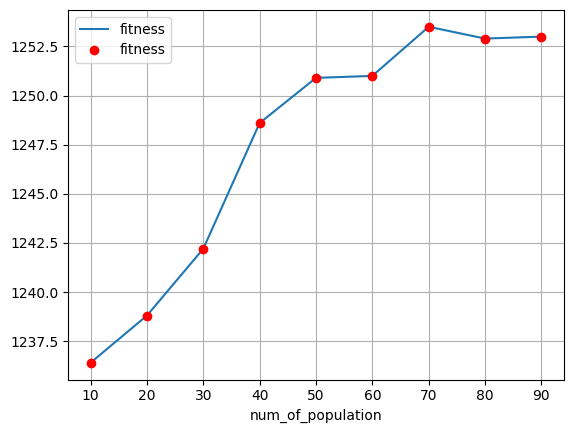

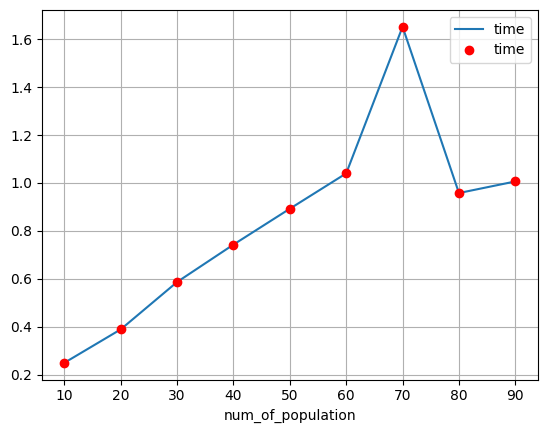

In [81]:
ax = pd.DataFrame(sorted(result2, key=lambda x: x['num_of_population'])).plot(x = "num_of_population", y="fitness")
pd.DataFrame(result2).plot(x = "num_of_population", y="fitness", style='ro', ax=ax, grid=True)

ax = pd.DataFrame(sorted(result2, key=lambda x: x['num_of_population'])).plot(x = "num_of_population", y="time")
pd.DataFrame(result2).plot(x = "num_of_population", y="time", style='ro', ax=ax, grid=True)

In [101]:
MUTATION_RATE = 0.01
REPRODUCTION_RATE = 0.1
POPULATION_COUNT = 30 
MIGRATION_PERIOD = 5
BEST_IN_MIGRATION = 4
IMMIGRANTS_NUM = 3
NUM_OF_POPUlATIONS = 50

In [83]:
solution = parallel_knapsack()
solution.counts, solution.fitness()

([0, 0, 0, 1, 62, 0, 0, 0, 0, 0], 1245)

In [84]:
r_mr = []
for mr in np.linspace(*params["mutation_rate"]):
    MUTATION_RATE = mr
    
    fitness = []
    start = time.time()
    for _ in range(10):
        solution = parallel_knapsack()
        fitness.append(solution.fitness())
    end = (time.time() - start) / 10
    r_mr.append({
        "mutation_rate": mr,
        "fitness": sum(fitness) / len(fitness),
        "time": end,
    })
    print(r_mr[-1])

{'mutation_rate': 0.005, 'fitness': 1253.6, 'time': 0.5643758058547974}
{'mutation_rate': 0.01, 'fitness': 1253.0, 'time': 0.5637225389480591}
{'mutation_rate': 0.015, 'fitness': 1251.6, 'time': 0.565151596069336}
{'mutation_rate': 0.02, 'fitness': 1250.5, 'time': 0.6018425464630127}


<AxesSubplot: xlabel='mutation_rate'>

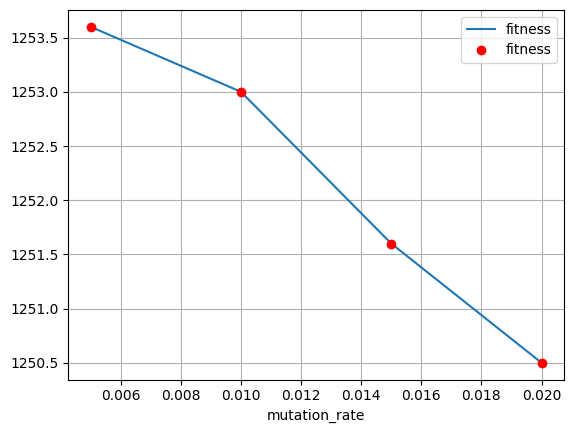

In [85]:
ax = pd.DataFrame(r_mr).plot(x = "mutation_rate", y="fitness")
pd.DataFrame(r_mr).plot(x = "mutation_rate", y="fitness", style='ro', ax=ax, grid=True)

In [86]:
MUTATION_RATE = 0.01
REPRODUCTION_RATE = 0.1
POPULATION_COUNT = 30 
MIGRATION_PERIOD = 5
BEST_IN_MIGRATION = 4
IMMIGRANTS_NUM = 3
NUM_OF_POPUlATIONS = 50

In [87]:
r_rr = []
for rr in np.linspace(*params["reproduction_rate"]):
    REPRODUCTION_RATE = rr
    
    fitness = []
    start = time.time()
    for _ in range(10):
        solution = parallel_knapsack()
        fitness.append(solution.fitness())
    end = (time.time() - start) / 10
    r_rr.append({
        "reproduction_rate": rr,
        "fitness": sum(fitness) / len(fitness),
        "time": end,
    })
    print(r_rr[-1])

{'reproduction_rate': 0.1, 'fitness': 1250.6, 'time': 0.5654408693313598}
{'reproduction_rate': 0.2, 'fitness': 1251.3, 'time': 0.5813473463058472}
{'reproduction_rate': 0.30000000000000004, 'fitness': 1251.1, 'time': 0.6421777486801148}
{'reproduction_rate': 0.4, 'fitness': 1253.2, 'time': 0.6917750835418701}


<AxesSubplot: xlabel='reproduction_rate'>

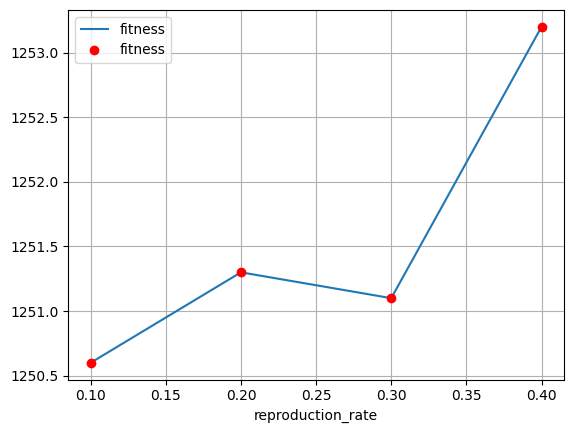

In [88]:
ax = pd.DataFrame(r_rr).plot(x = "reproduction_rate", y="fitness")
pd.DataFrame(r_rr).plot(x = "reproduction_rate", y="fitness", style='ro', ax=ax, grid=True)

In [89]:
MUTATION_RATE = 0.01
REPRODUCTION_RATE = 0.1
POPULATION_COUNT = 30 
MIGRATION_PERIOD = 5
BEST_IN_MIGRATION = 4
IMMIGRANTS_NUM = 3
NUM_OF_POPUlATIONS = 50

In [90]:
r_pc = []
for pc in range(10, 41, 10):
    POPULATION_COUNT = int(pc)
    
    fitness = []
    start = time.time()
    for _ in range(10):
        solution = parallel_knapsack()
        fitness.append(solution.fitness())
    end = (time.time() - start) / 10
    r_pc.append({
        "population_count": pc,
        "fitness": sum(fitness) / len(fitness),
        "time": end,
    })
    print(r_pc[-1])

{'population_count': 10, 'fitness': 1252.4, 'time': 0.5589239835739136}
{'population_count': 20, 'fitness': 1248.7, 'time': 0.5760136127471924}
{'population_count': 30, 'fitness': 1252.2, 'time': 0.7010989189147949}
{'population_count': 40, 'fitness': 1250.1, 'time': 0.7417223215103149}


<AxesSubplot: xlabel='population_count'>

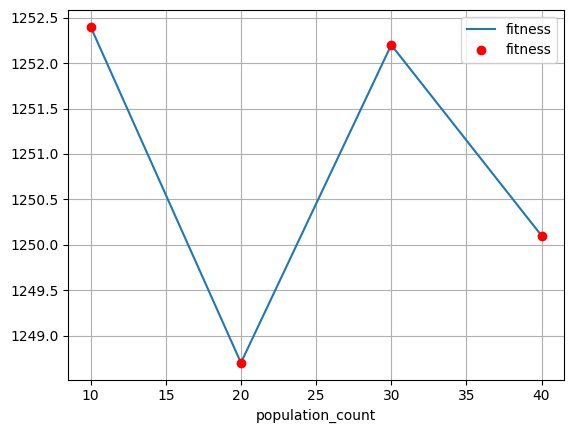

In [91]:
ax = pd.DataFrame(r_pc).plot(x = "population_count", y="fitness")
pd.DataFrame(r_pc).plot(x = "population_count", y="fitness", style='ro', ax=ax, grid=True)

In [92]:
MUTATION_RATE = 0.01
REPRODUCTION_RATE = 0.1
POPULATION_COUNT = 30 
MIGRATION_PERIOD = 5
BEST_IN_MIGRATION = 4
IMMIGRANTS_NUM = 3
NUM_OF_POPUlATIONS = 50

In [93]:
r_mnp = []
for mnp in np.linspace(*params["migration_period"]):
    MIGRATION_PERIOD = int(mnp)
    
    fitness = []
    start = time.time()
    for _ in range(10):
        solution = parallel_knapsack()
        fitness.append(solution.fitness())
    end = (time.time() - start) / 10
    r_mnp.append({
        "migration_period": mnp,
        "fitness": sum(fitness) / len(fitness),
        "time": end,
    })
    print(r_mnp[-1])

{'migration_period': 5.0, 'fitness': 1252.5, 'time': 0.6460672378540039}
{'migration_period': 20.0, 'fitness': 1250.0, 'time': 0.6954353094100952}
{'migration_period': 35.0, 'fitness': 1251.6, 'time': 0.6597020864486695}
{'migration_period': 50.0, 'fitness': 1247.7, 'time': 0.7063162565231323}


<AxesSubplot: xlabel='migration_period'>

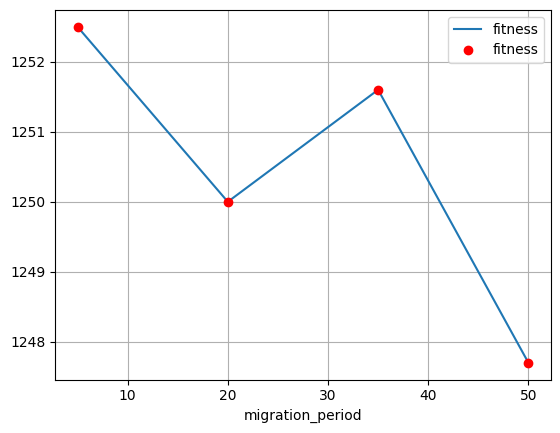

In [94]:
ax = pd.DataFrame(r_mnp).plot(x = "migration_period", y="fitness")
pd.DataFrame(r_mnp).plot(x = "migration_period", y="fitness", style='ro', ax=ax, grid=True)

In [95]:
MUTATION_RATE = 0.01
REPRODUCTION_RATE = 0.1
POPULATION_COUNT = 30 
MIGRATION_PERIOD = 5
BEST_IN_MIGRATION = 4
IMMIGRANTS_NUM = 3
NUM_OF_POPUlATIONS = 50

In [96]:
r_bm = []
for bm in np.linspace(*params["best_in_migration"]):
    BEST_IN_MIGRATION = int(bm)
    
    fitness = []
    start = time.time()
    for _ in range(10):
        solution = parallel_knapsack()
        fitness.append(solution.fitness())
    end = (time.time() - start) / 10
    r_bm.append({
        "best_in_migration": bm,
        "fitness": sum(fitness) / len(fitness),
        "time": end,
    })
    print(r_bm[-1])

{'best_in_migration': 3.0, 'fitness': 1250.5, 'time': 0.734141755104065}
{'best_in_migration': 4.0, 'fitness': 1250.6, 'time': 0.662555456161499}
{'best_in_migration': 5.0, 'fitness': 1251.5, 'time': 0.6759563684463501}


<AxesSubplot: xlabel='best_in_migration'>

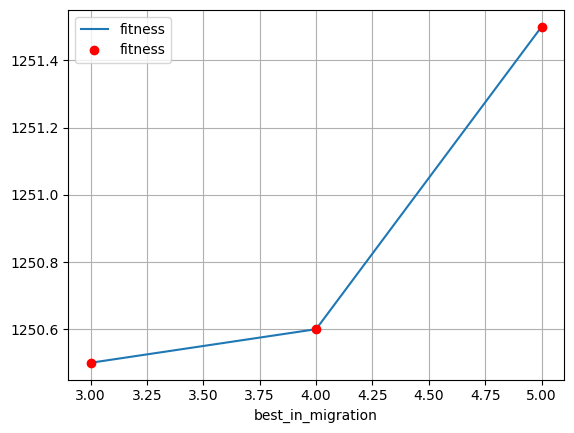

In [97]:
ax = pd.DataFrame(r_bm).plot(x = "best_in_migration", y="fitness")
pd.DataFrame(r_bm).plot(x = "best_in_migration", y="fitness", style='ro', ax=ax, grid=True)

In [2]:
MUTATION_RATE = 0.01
REPRODUCTION_RATE = 0.1
POPULATION_COUNT = 30 
MIGRATION_PERIOD = 5
BEST_IN_MIGRATION = 4
IMMIGRANTS_NUM = 3
NUM_OF_POPUlATIONS = 50

In [99]:
r_imn = []
for imn in np.linspace(*params["immigrants_num"]):
    IMMIGRANTS_NUM = int(imn)
    
    fitness = []
    start = time.time()
    for _ in range(10):
        solution = parallel_knapsack()
        fitness.append(solution.fitness())
    end = (time.time() - start) / 10
    r_imn.append({
        "immigrants_num": imn,
        "fitness": sum(fitness) / len(fitness),
        "time": end,
    })
    print(r_imn[-1])

{'immigrants_num': 1.0, 'fitness': 1251.3, 'time': 0.6058454751968384}
{'immigrants_num': 2.0, 'fitness': 1252.0, 'time': 0.6298528194427491}
{'immigrants_num': 3.0, 'fitness': 1253.1, 'time': 0.5701021909713745}


<AxesSubplot: xlabel='immigrants_num'>

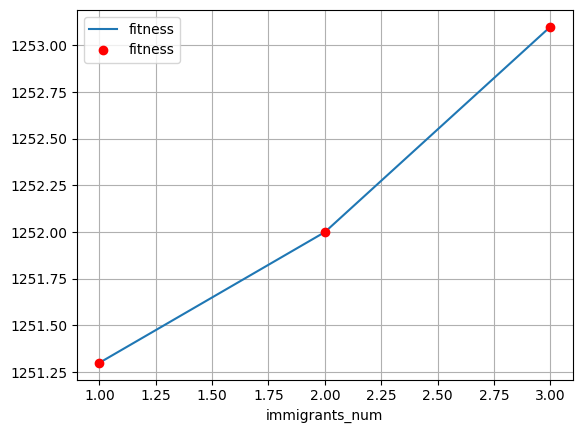

In [100]:
ax = pd.DataFrame(r_imn).plot(x = "immigrants_num", y="fitness")
pd.DataFrame(r_imn).plot(x = "immigrants_num", y="fitness", style='ro', ax=ax, grid=True)